In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import( accuracy_score,
                           confusion_matrix,
                           classification_report,
                          roc_auc_score,
                          roc_curve,
                          auc,
                          plot_confusion_matrix,
                          plot_roc_curve)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


from tensorflow.keras.metrics import AUC
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

pd.set_option ('display.float','{:0.2f}'.format)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)


In [3]:
df=pd.read_csv('train.csv')
df.head()

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
0,816393,40-64,female,20-29y,university,middle class,0.64,0,after 2015,0,0,37379,11000,0,0,0,0,Sports Car
1,251762,26-39,male,20-29y,high school,middle class,0.48,1,before 2015,1,0,10238,9000,0,0,0,1,HatchBack
2,481952,40-64,male,20-29y,none,middle class,0.84,1,before 2015,1,1,10238,12000,0,0,0,1,Sedan
3,3506,40-64,male,20-29y,high school,upper class,0.68,1,before 2015,0,1,92099,6000,1,0,0,1,Sedan
4,498013,40-64,female,20-29y,none,working class,0.57,1,after 2015,1,1,32122,15000,0,0,1,0,Sedan


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87285 entries, 0 to 87284
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   87285 non-null  int64  
 1   AGE                  87285 non-null  object 
 2   GENDER               87285 non-null  object 
 3   DRIVING_EXPERIENCE   87285 non-null  object 
 4   EDUCATION            87285 non-null  object 
 5   INCOME               87285 non-null  object 
 6   CREDIT_SCORE         87285 non-null  float64
 7   VEHICLE_OWNERSHIP    87285 non-null  int64  
 8   VEHICLE_YEAR         87285 non-null  object 
 9   MARRIED              87285 non-null  int64  
 10  CHILDREN             87285 non-null  int64  
 11  POSTAL_CODE          87285 non-null  int64  
 12  ANNUAL_MILEAGE       87285 non-null  int64  
 13  SPEEDING_VIOLATIONS  87285 non-null  int64  
 14  DUIS                 87285 non-null  int64  
 15  PAST_ACCIDENTS       87285 non-null 

In [13]:
df.describe()

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,87285.00,87285.00,87285.00,87285.00,87285.00,87285.00,87285.00,87285.00,87285.00,87285.00,87285.00
mean,394798.84,0.60,0.83,0.58,0.52,18036.28,11056.42,0.68,0.13,0.55,0.42
std,279746.73,0.14,0.38,0.49,0.50,16724.52,2977.06,1.39,0.59,1.40,0.49
min,101.00,0.07,0.00,0.00,0.00,10238.00,2000.00,0.00,0.00,0.00,0.00
25%,156345.00,0.51,1.00,0.00,0.00,10238.00,9000.00,0.00,0.00,0.00,0.00
50%,353756.00,0.60,1.00,1.00,1.00,10238.00,11000.00,0.00,0.00,0.00,0.00
75%,598618.00,0.70,1.00,1.00,1.00,22320.00,13000.00,1.00,0.00,0.00,1.00
max,999976.00,0.95,1.00,1.00,1.00,92101.00,21000.00,20.00,6.00,15.00,1.00


In [14]:
df.describe(include='object')

,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,VEHICLE_YEAR,TYPE_OF_VEHICLE
count,87285,87285,87285,87285,87285,87285,87285
unique,4,2,4,3,4,2,4
top,40-64,male,20-29y,high school,upper class,before 2015,Sports Car
freq,27967,54379,31171,38746,42685,47738,28723


# EDA

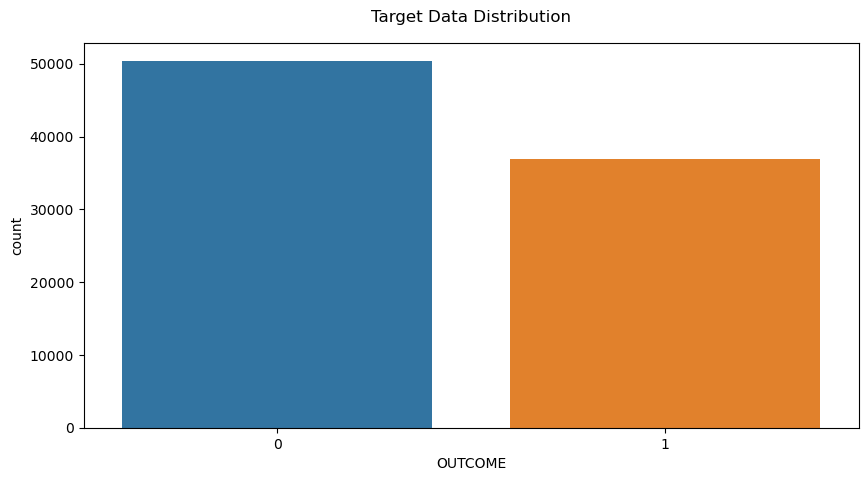

In [15]:
plt.figure(figsize=(10, 5))
sns.countplot(x='OUTCOME', data=df)
plt.title("Target Data Distribution", pad=15);

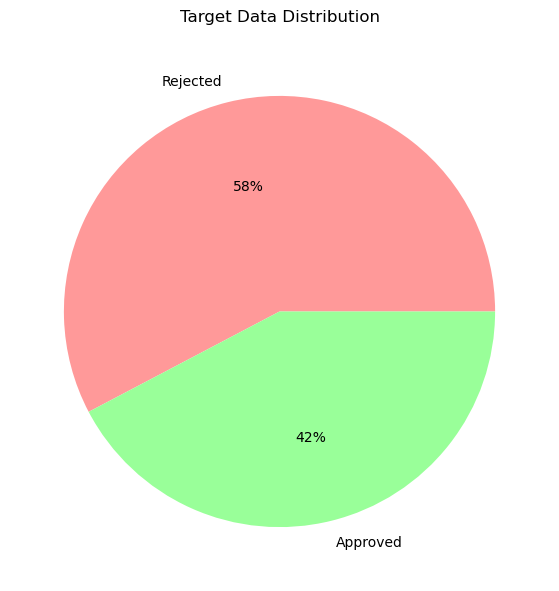

In [16]:
df1 = df['OUTCOME'].value_counts().reset_index()

plt.figure(figsize=(12, 7))
plt.pie(df1['OUTCOME'], labels=['Rejected','Approved'], 
        colors=['#ff9999','#99ff99'], autopct='%.0f%%')
plt.title("Target Data Distribution", pad=15);

# Feature-wise EDA

## Age

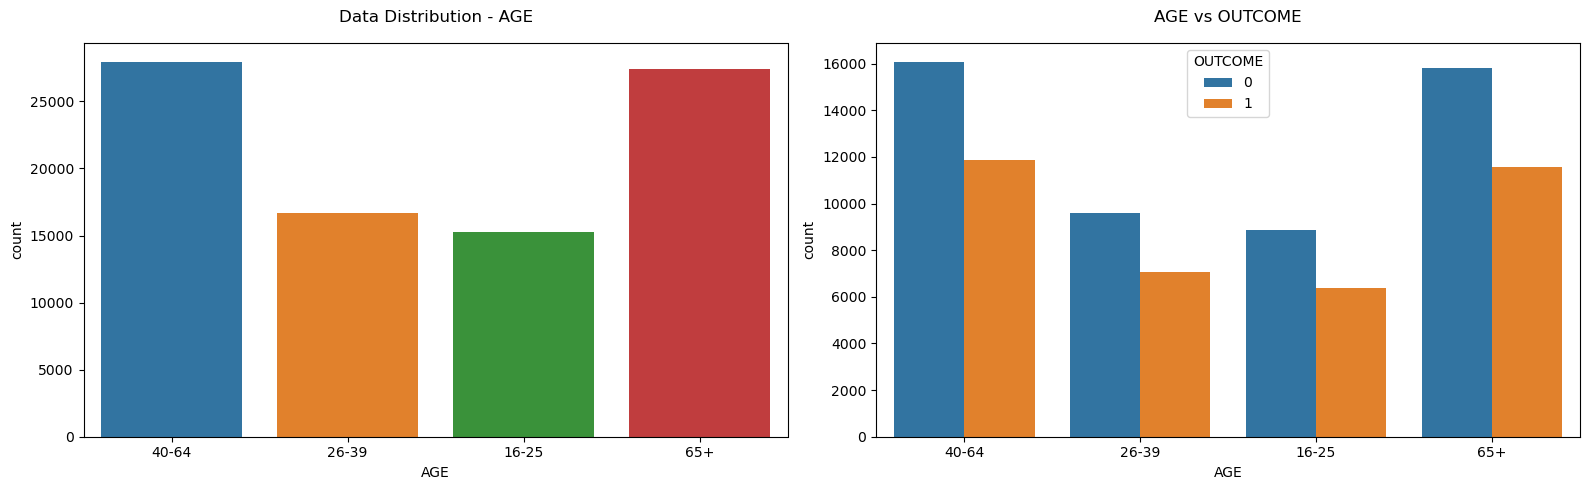

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(x='AGE', data=df, ax=ax[0])
sns.countplot(x='AGE', hue='OUTCOME', data=df, ax=ax[1])
ax[0].set_title(f"Data Distribution - AGE", pad=15)
ax[1].set_title(f"AGE vs OUTCOME", pad=15)
fig.tight_layout();

## Gender

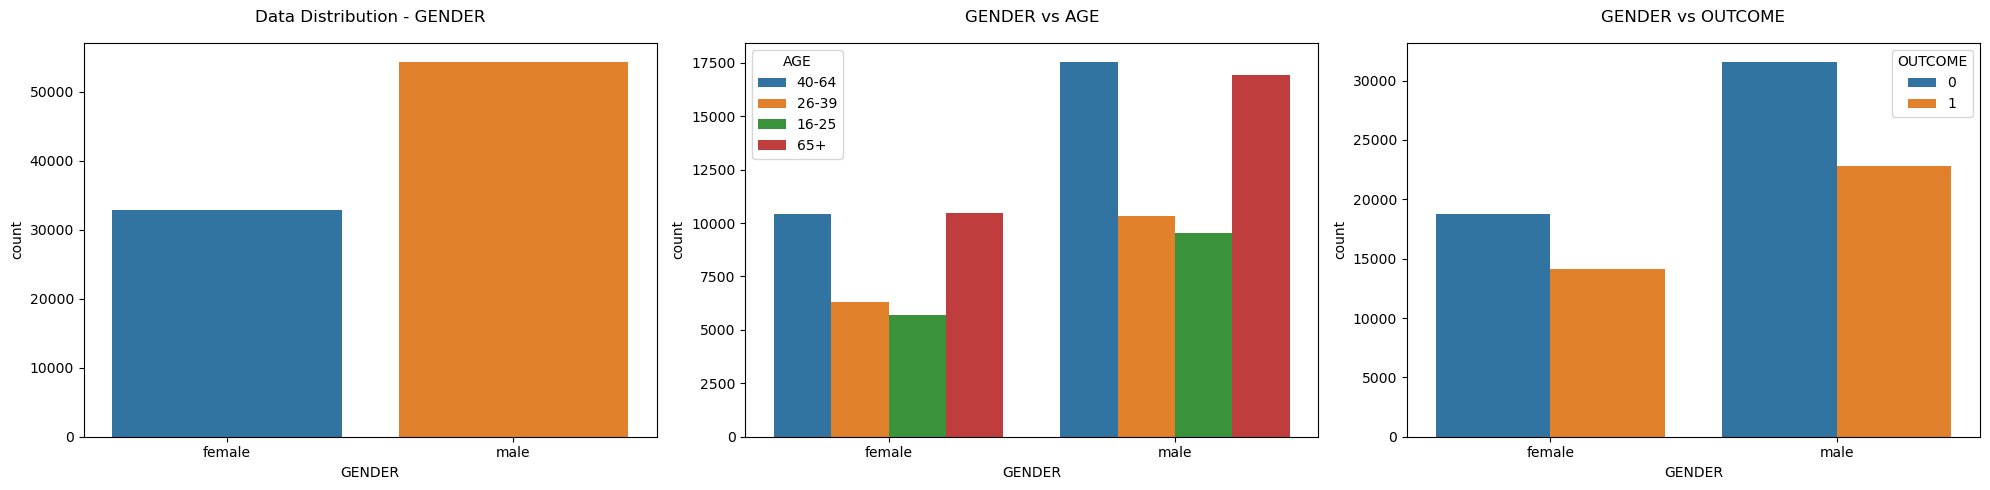

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(x='GENDER', data=df, ax=ax[0])
sns.countplot(x='GENDER', hue='AGE', data=df, ax=ax[1])
sns.countplot(x='GENDER', hue='OUTCOME', data=df, ax=ax[2])
ax[0].set_title(f"Data Distribution - GENDER", pad=15)
ax[1].set_title(f"GENDER vs AGE", pad=15)
ax[2].set_title(f"GENDER vs OUTCOME", pad=15)
fig.tight_layout();

## DRIVING_EXPERIENCE

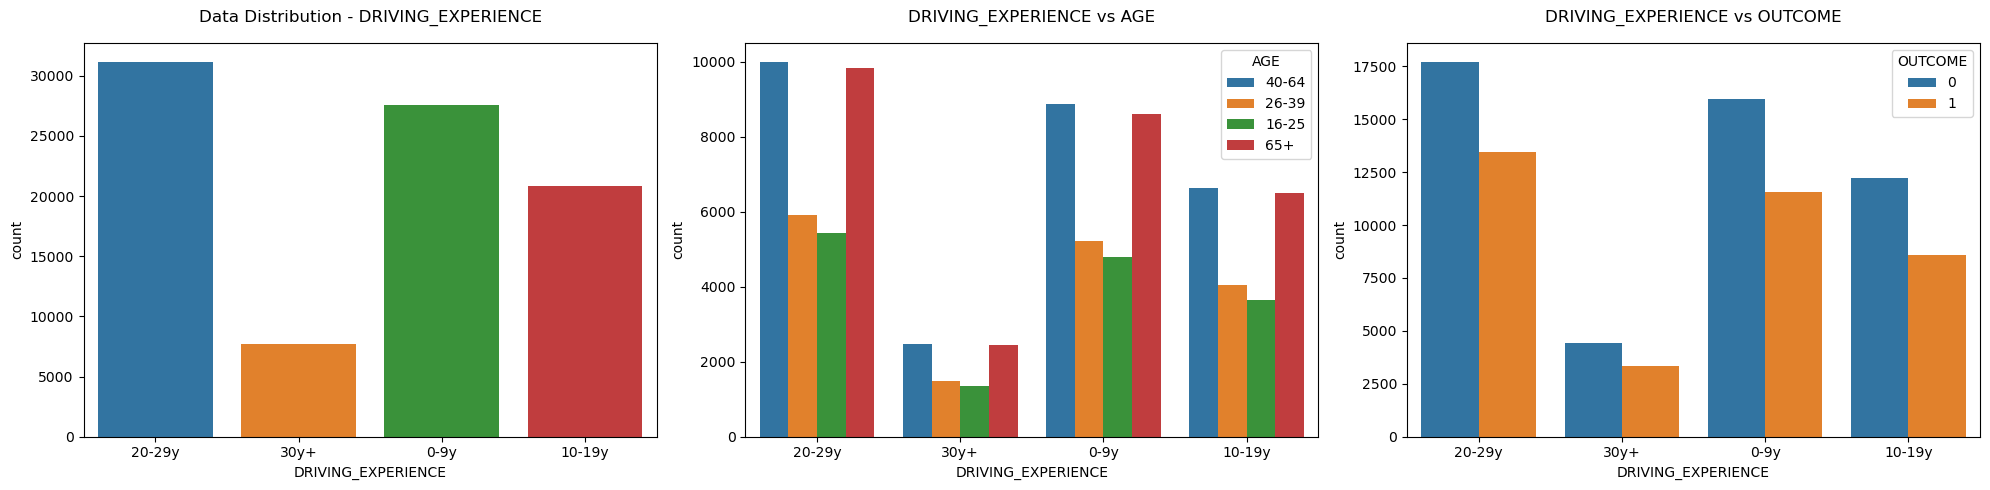

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(x='DRIVING_EXPERIENCE', data=df, ax=ax[0])
sns.countplot(x='DRIVING_EXPERIENCE', hue='AGE', data=df, ax=ax[1])
sns.countplot(x='DRIVING_EXPERIENCE', hue='OUTCOME', data=df, ax=ax[2])
ax[0].set_title(f"Data Distribution - DRIVING_EXPERIENCE", pad=15)
ax[1].set_title(f"DRIVING_EXPERIENCE vs AGE", pad=15)
ax[2].set_title(f"DRIVING_EXPERIENCE vs OUTCOME", pad=15)
fig.tight_layout();

## EDUCATION

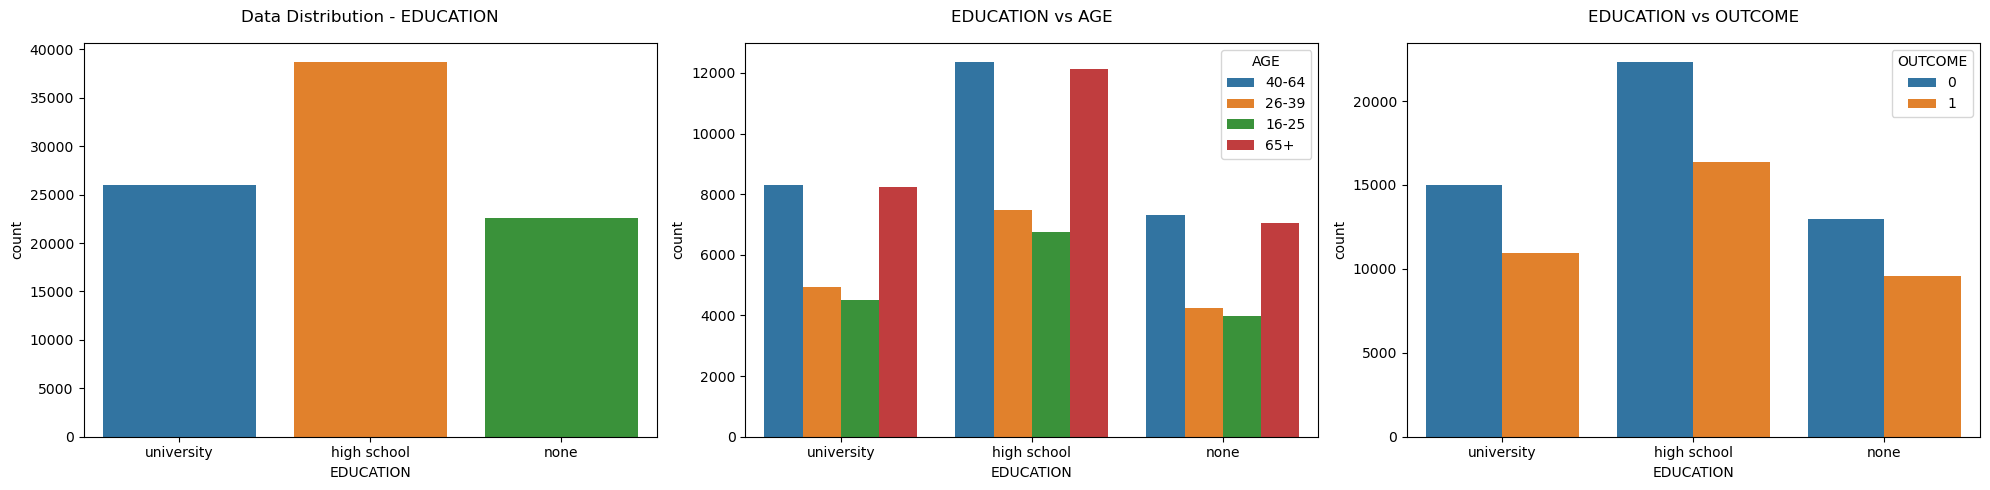

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(x='EDUCATION', data=df, ax=ax[0])
sns.countplot(x='EDUCATION', hue='AGE', data=df, ax=ax[1])
sns.countplot(x='EDUCATION', hue='OUTCOME', data=df, ax=ax[2])
ax[0].set_title(f"Data Distribution - EDUCATION", pad=15)
ax[1].set_title(f"EDUCATION vs AGE", pad=15)
ax[2].set_title(f"EDUCATION vs OUTCOME", pad=15)
fig.tight_layout();

## INCOME

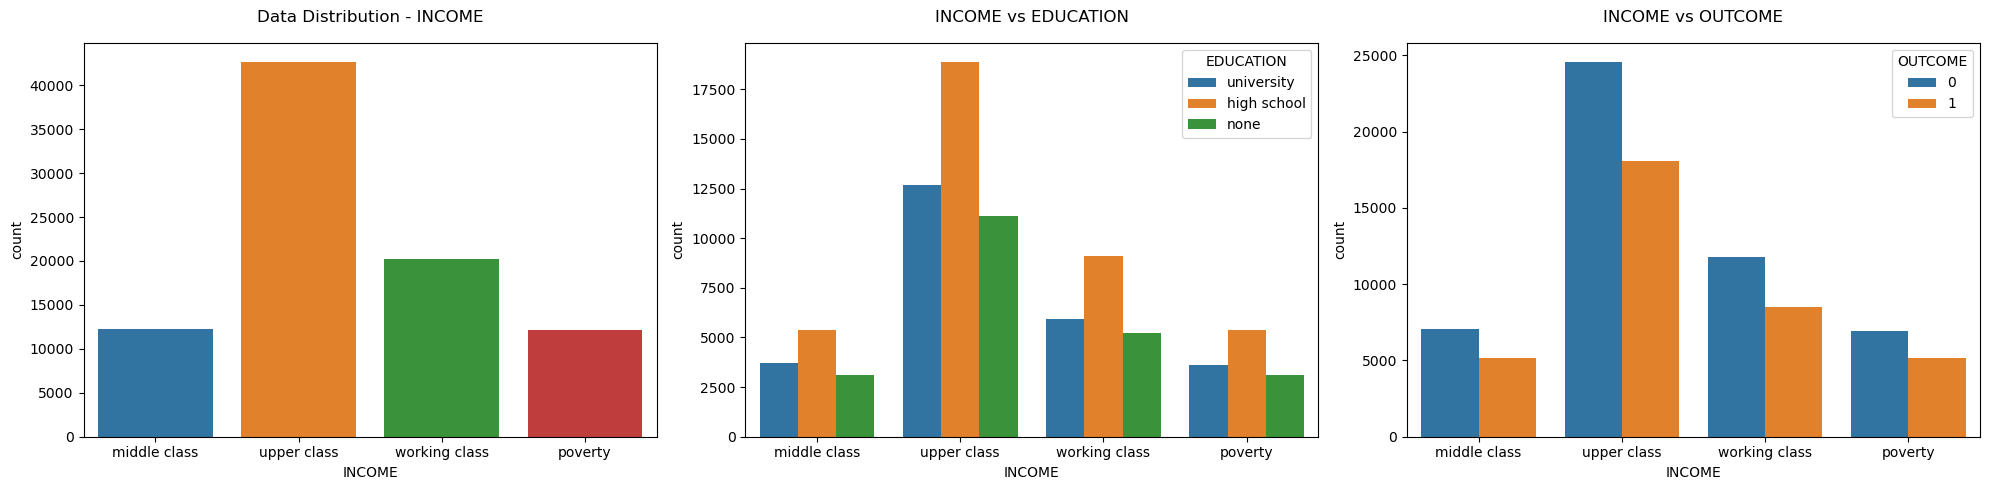

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(x='INCOME', data=df, ax=ax[0])
sns.countplot(x='INCOME', hue='EDUCATION', data=df, ax=ax[1])
sns.countplot(x='INCOME', hue='OUTCOME', data=df, ax=ax[2])
ax[0].set_title(f"Data Distribution - INCOME", pad=15)
ax[1].set_title(f"INCOME vs EDUCATION", pad=15)
ax[2].set_title(f"INCOME vs OUTCOME", pad=15)
fig.tight_layout();

## CREDIT_SCORE

In [23]:
df['CREDIT_SCORE_BIN'] = df['CREDIT_SCORE'].apply(lambda x: 0 if x<=0.2 
                                                        else 1 if x>0.2 and x<=0.4 
                                                        else 2 if x>0.4 and x<=0.6 
                                                        else 3 if x>0.6 and x<=0.8 
                                                        else 4)

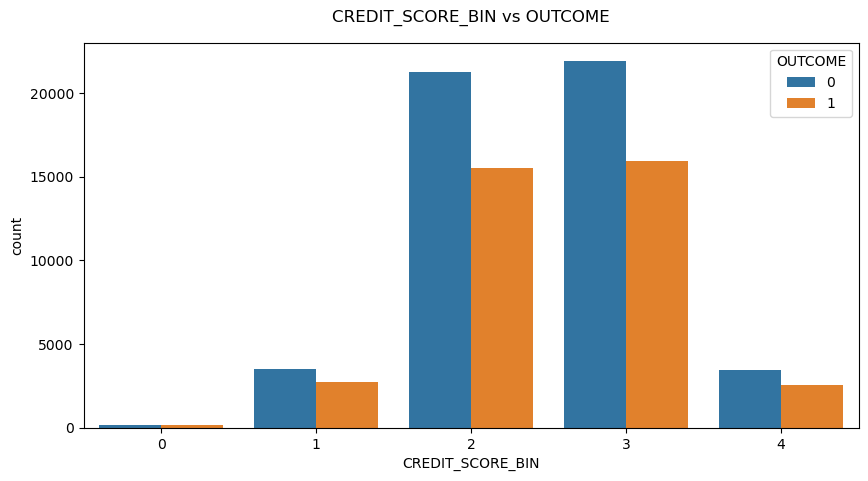

In [24]:
plt.figure(figsize=(10, 5))
sns.countplot(x='CREDIT_SCORE_BIN', hue='OUTCOME', data=df)
plt.title("CREDIT_SCORE_BIN vs OUTCOME", pad=15);

## VEHICLE_OWNERSHIP

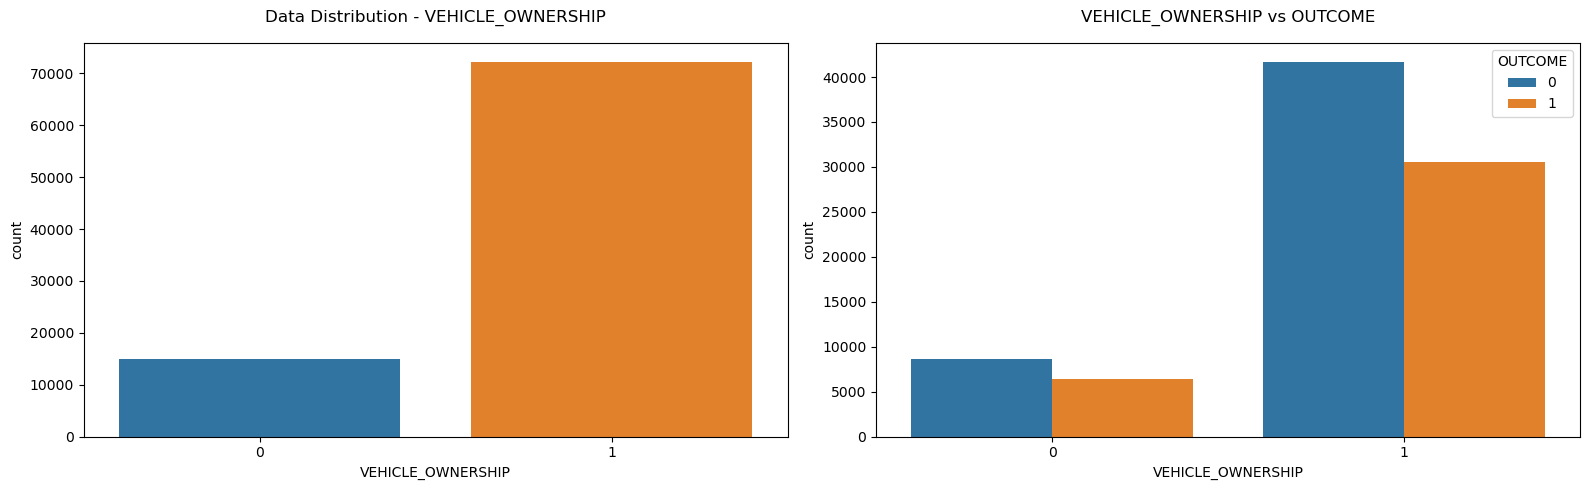

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(x='VEHICLE_OWNERSHIP', data=df, ax=ax[0])
sns.countplot(x='VEHICLE_OWNERSHIP', hue='OUTCOME', data=df, ax=ax[1])
ax[0].set_title(f"Data Distribution - VEHICLE_OWNERSHIP", pad=15)
ax[1].set_title(f"VEHICLE_OWNERSHIP vs OUTCOME", pad=15)
fig.tight_layout();

## VEHICLE_YEAR

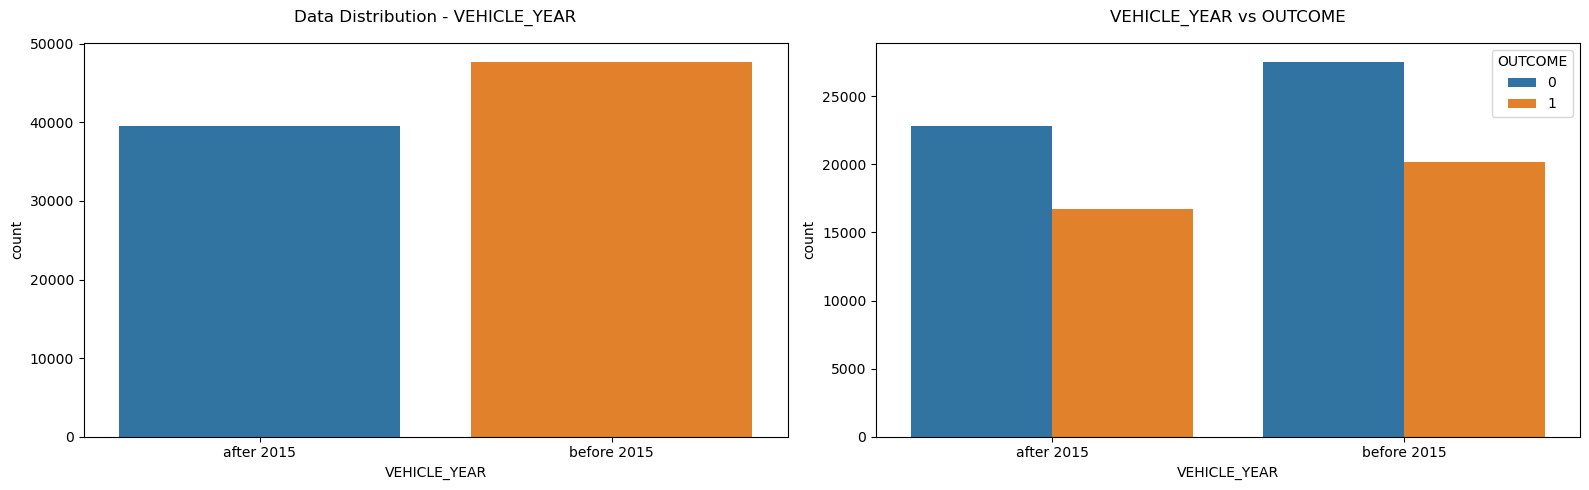

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(x='VEHICLE_YEAR', data=df, ax=ax[0])
sns.countplot(x='VEHICLE_YEAR', hue='OUTCOME', data=df, ax=ax[1])
ax[0].set_title(f"Data Distribution - VEHICLE_YEAR", pad=15)
ax[1].set_title(f"VEHICLE_YEAR vs OUTCOME", pad=15)
fig.tight_layout();

## MARRIED

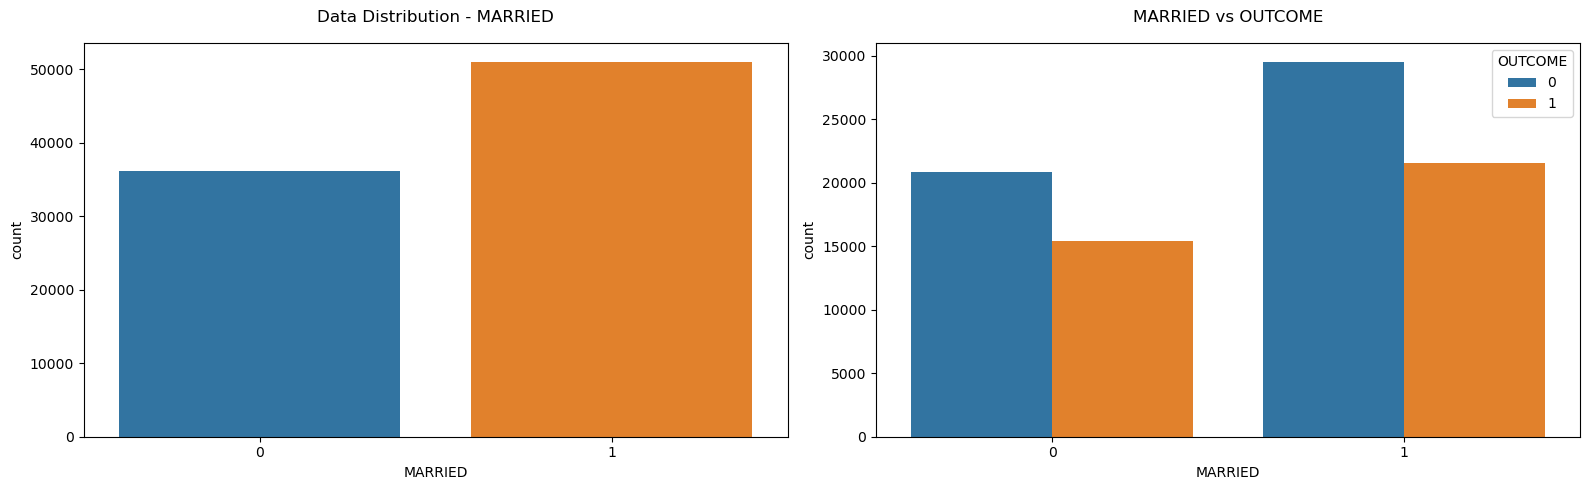

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(x='MARRIED', data=df, ax=ax[0])
sns.countplot(x='MARRIED', hue='OUTCOME', data=df, ax=ax[1])
ax[0].set_title(f"Data Distribution - MARRIED", pad=15)
ax[1].set_title(f"MARRIED vs OUTCOME", pad=15)
fig.tight_layout();

## CHILDREN

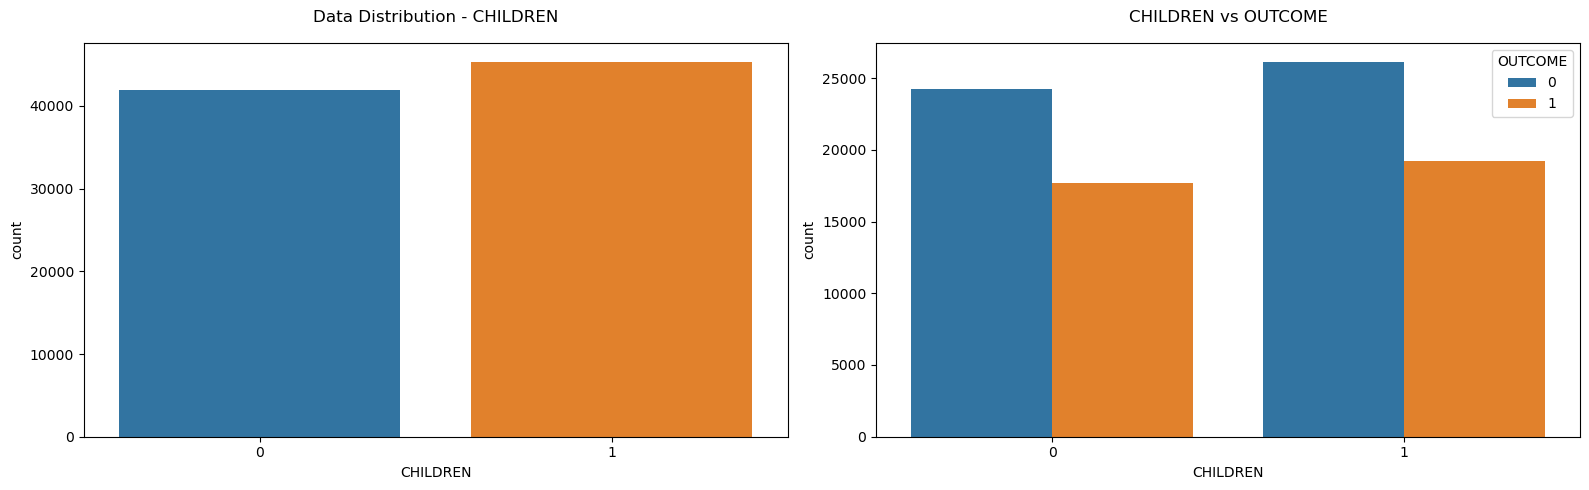

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(x='CHILDREN', data=df, ax=ax[0])
sns.countplot(x='CHILDREN', hue='OUTCOME', data=df, ax=ax[1])
ax[0].set_title(f"Data Distribution - CHILDREN", pad=15)
ax[1].set_title(f"CHILDREN vs OUTCOME", pad=15)
fig.tight_layout();

## POSTAL_CODE

In [31]:
df['US_STATE'] = df['POSTAL_CODE'].apply(
    lambda x: 
    'AL' if x>=35004 and x<=36925 else
    'AK' if x>=99501 and x<=99950 else
    'AZ' if x>=85001 and x<=86556 else
    'AR' if x>=71601 and x<=72959 else
    'CA' if x>=90001 and x<=96162 else
    'CO' if x>=80001 and x<=81658 else
    'CT' if x>=6001  and x<=6928  else
    'DE' if x>=19701 and x<=19980 else
    'FL' if x>=32003 and x<=34997 else
    'GA' if x>=30002 and x<=39901 else
    'HI' if x>=96701 and x<=96898 else
    'ID' if x>=83201 and x<=83877 else
    'IL' if x>=60001 and x<=62999 else
    'IN' if x>=46001 and x<=47997 else
    'IA' if x>=50001 and x<=52809 else
    'KS' if x>=66002 and x<=67954 else
    'KY' if x>=40003 and x<=42788 else
    'LA' if x>=70001 and x<=71497 else
    'ME' if x>=3901  and x<=4992  else
    'MD' if x>=20588 and x<=21930 else
    'MA' if x>=1001  and x<=5544  else
    'MI' if x>=48001 and x<=49971 else
    'MN' if x>=55001 and x<=56763 else
    'MS' if x>=38601 and x<=39776 else
    'MO' if x>=63001 and x<=65899 else
    'MT' if x>=59001 and x<=59937 else
    'NE' if x>=68001 and x<=69367 else
    'NV' if x>=88901 and x<=89883 else
    'NH' if x>=3031  and x<=3897  else
    'NJ' if x>=7001  and x<=8989  else
    'NM' if x>=87001 and x<=88439 else
    'NY' if x>=501   and x<=14925 else
    'NC' if x>=27006 and x<=28909 else
    'ND' if x>=58001 and x<=58856 else
    'OH' if x>=43001 and x<=45999 else
    'OK' if x>=73001 and x<=74966 else
    'OR' if x>=97001 and x<=97920 else
    'PA' if x>=15001 and x<=19640 else
    'RI' if x>=2801  and x<=2940  else
    'SC' if x>=29001 and x<=29945 else
    'SD' if x>=57001 and x<=57799 else
    'TN' if x>=37010 and x<=38589 else
    'TX' if x>=73301 and x<=88595 else
    'UT' if x>=84001 and x<=84791 else
    'VT' if x>=5001  and x<=5907  else
    'VA' if x>=20101 and x<=24658 else
    'WA' if x>=98001 and x<=99403 else
    'WV' if x>=24701 and x<=26886 else
    'WI' if x>=53001 and x<=54990 else
    'WY' if x>=82001 and x<=83414 else
    'Not Available'
)

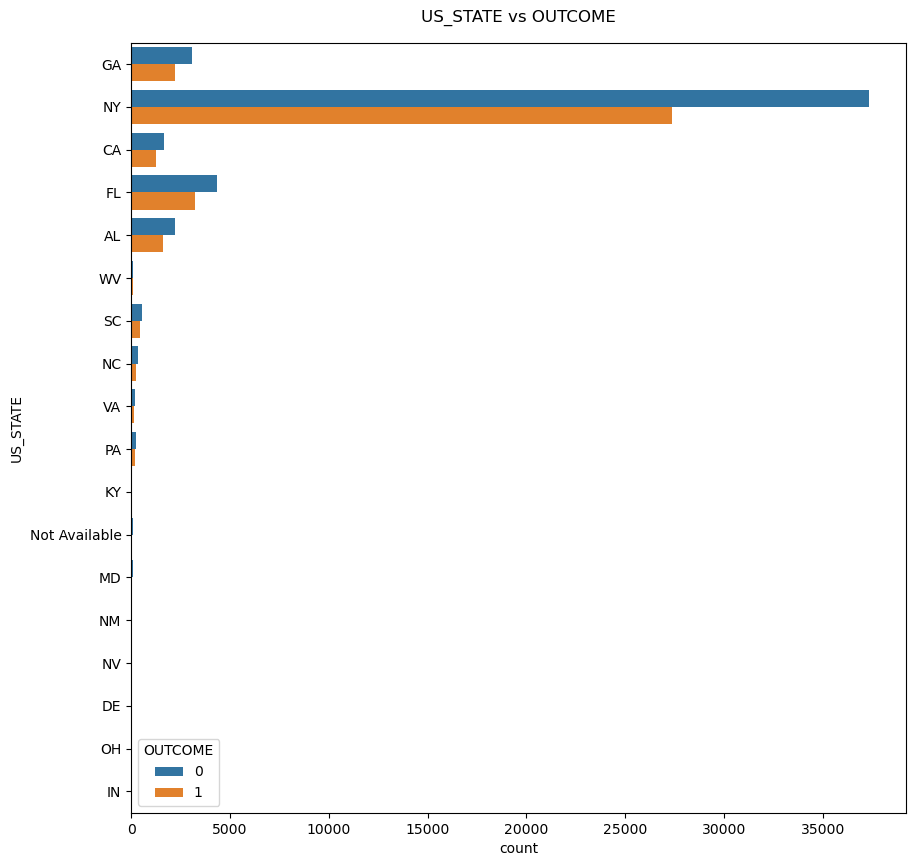

In [32]:
plt.figure(figsize=(10, 10))
sns.countplot(y='US_STATE', hue='OUTCOME', data=df)
plt.title(f"US_STATE vs OUTCOME", pad=15);

## ANNUAL_MILEAGE

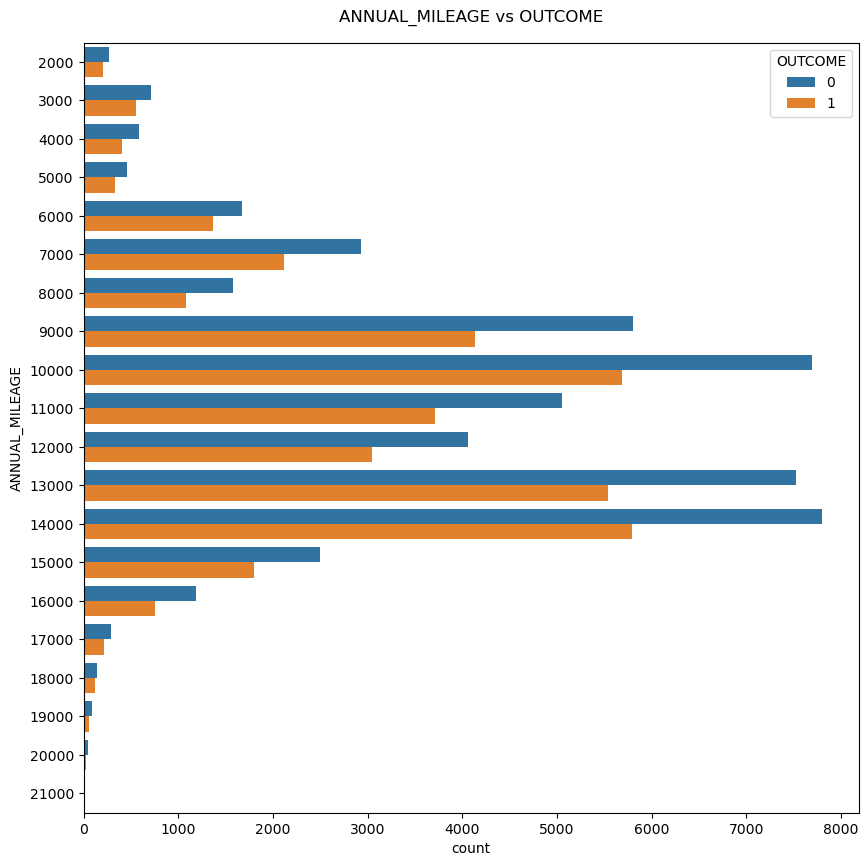

In [34]:
plt.figure(figsize=(10, 10))
sns.countplot(y='ANNUAL_MILEAGE', hue='OUTCOME', data=df)
plt.title(f"ANNUAL_MILEAGE vs OUTCOME", pad=15);

## SPEEDING_VIOLATIONS

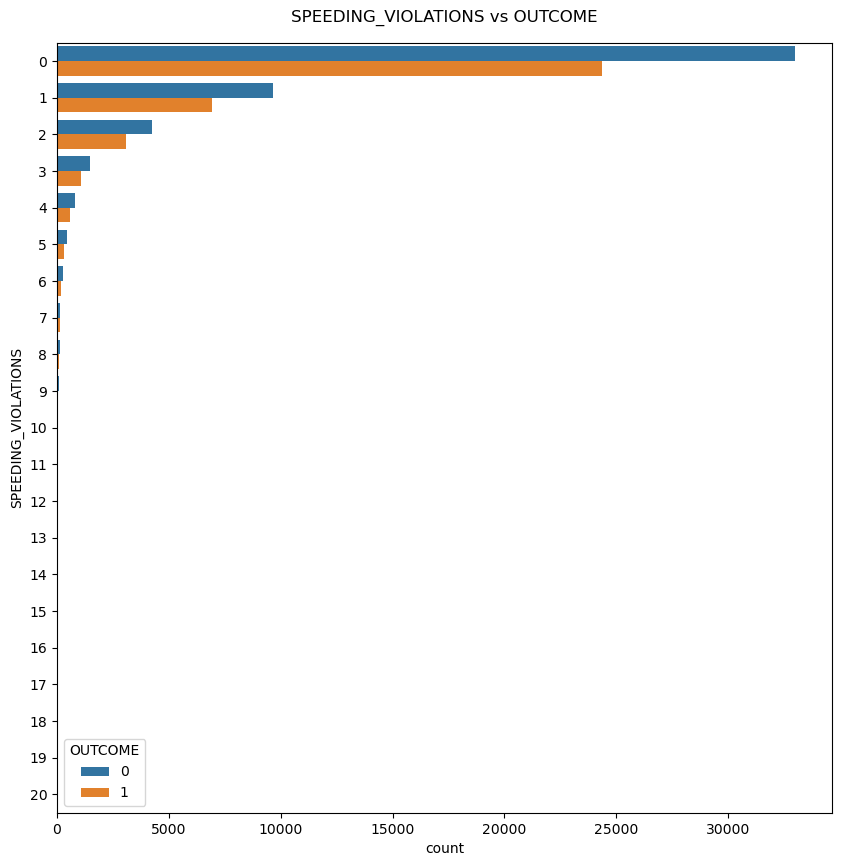

In [35]:
plt.figure(figsize=(10, 10))
sns.countplot(y='SPEEDING_VIOLATIONS', hue='OUTCOME', data=df)
plt.title(f"SPEEDING_VIOLATIONS vs OUTCOME", pad=15);

## DUIS

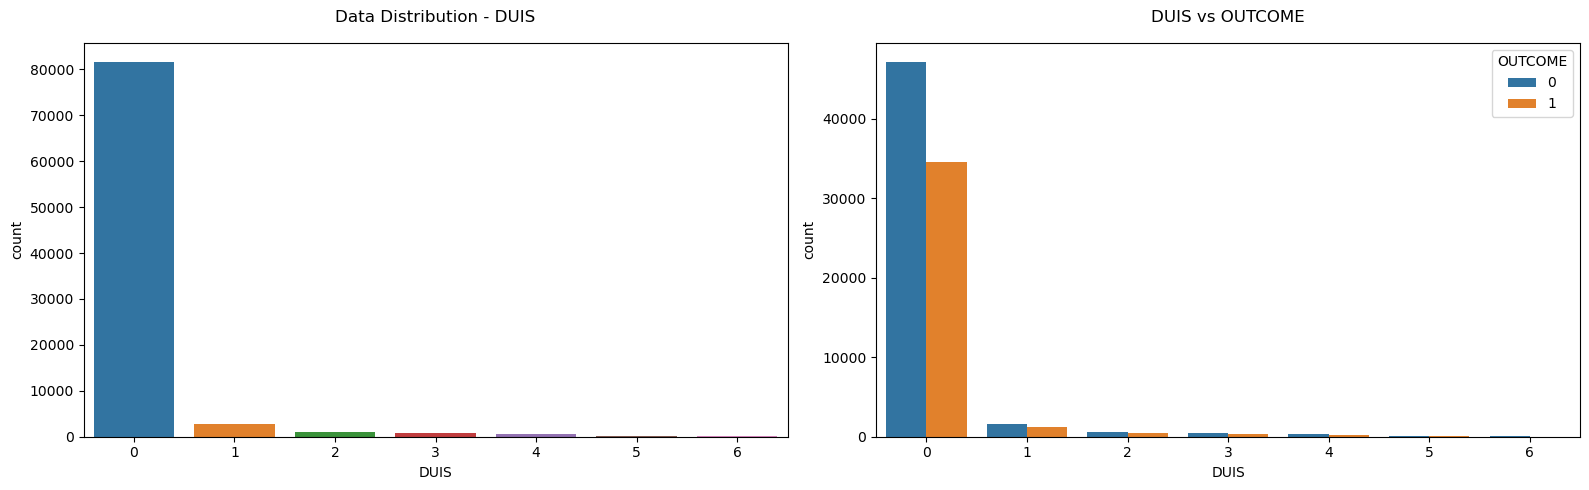

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(x='DUIS', data=df, ax=ax[0])
sns.countplot(x='DUIS', hue='OUTCOME', data=df, ax=ax[1])
ax[0].set_title(f"Data Distribution - DUIS", pad=15)
ax[1].set_title(f"DUIS vs OUTCOME", pad=15)
fig.tight_layout();

## PAST_ACCIDENTS

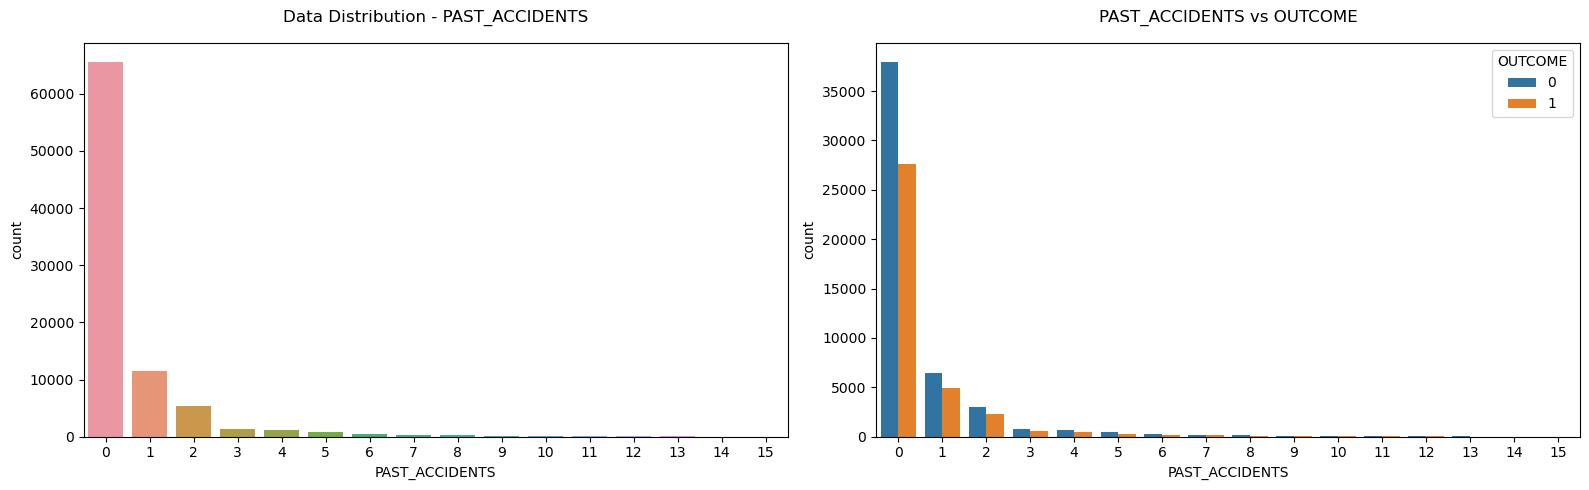

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(x='PAST_ACCIDENTS', data=df, ax=ax[0])
sns.countplot(x='PAST_ACCIDENTS', hue='OUTCOME', data=df, ax=ax[1])
ax[0].set_title(f"Data Distribution - PAST_ACCIDENTS", pad=15)
ax[1].set_title(f"PAST_ACCIDENTS vs OUTCOME", pad=15)
fig.tight_layout();

## TYPE_OF_VEHICLE

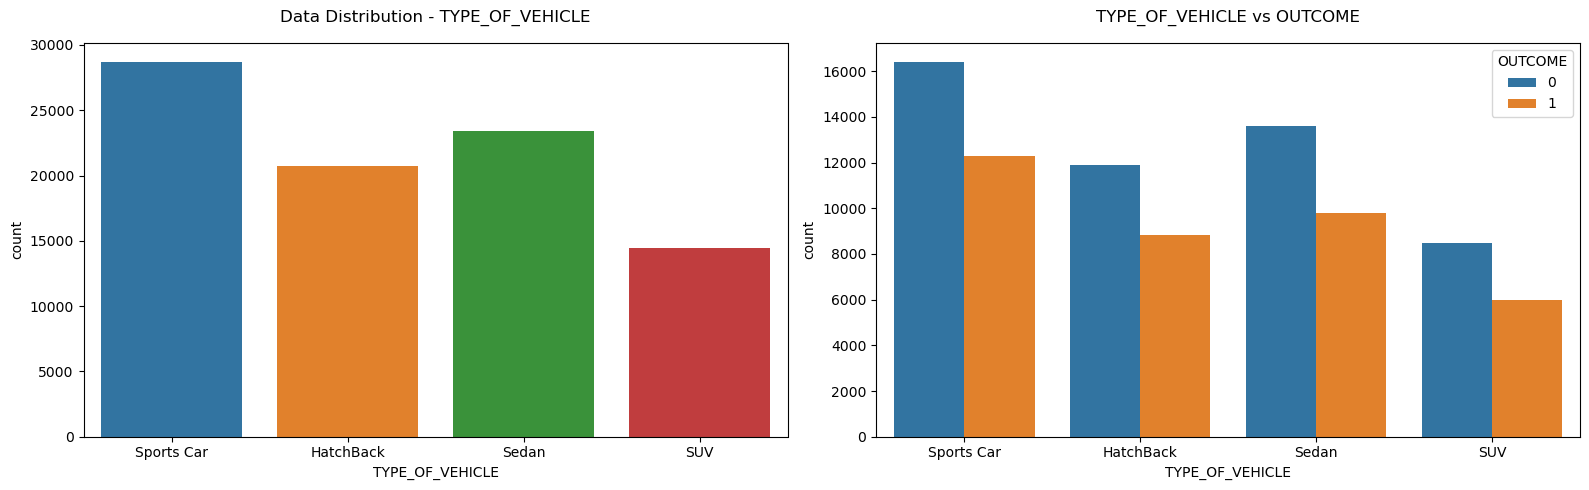

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(x='TYPE_OF_VEHICLE', data=df, ax=ax[0])
sns.countplot(x='TYPE_OF_VEHICLE', hue='OUTCOME', data=df, ax=ax[1])
ax[0].set_title(f"Data Distribution - TYPE_OF_VEHICLE", pad=15)
ax[1].set_title(f"TYPE_OF_VEHICLE vs OUTCOME", pad=15)
fig.tight_layout();

<AxesSubplot: >

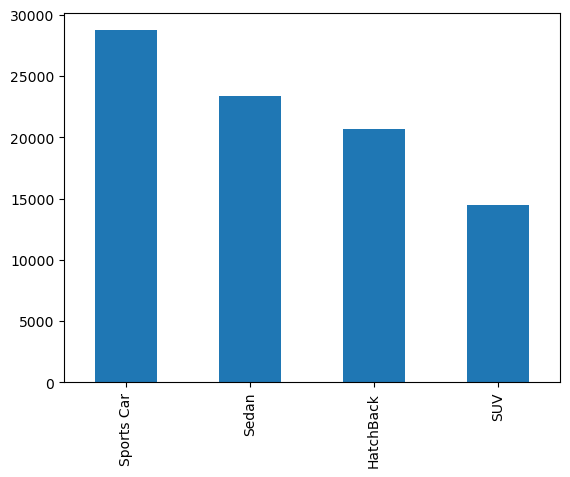

In [7]:
df.TYPE_OF_VEHICLE.value_counts().plot(kind='bar')